Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
(10585, 100, 100, 3)
(10585,)
2381
8204
0.2249
(2648, 100, 100, 3)
(2648,)
596
2052
0.2251


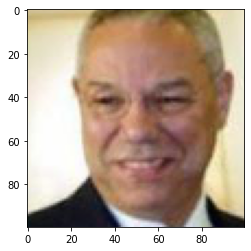

(10585, 100, 100, 3)
(2648, 100, 100, 3)
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cropping2d_7 (Cropping2D)    (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 32, 32, 16)        448       
_________________________________________________________________
activation_35 (Activation)   (None, 32, 32, 16)        0         
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 16, 16, 32)        4640      
_________________________________________________________________
activation_36 (Activation)   (None, 16, 16, 32)        0         
_________________________________________________________________
max_pooling2d

In [0]:
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, Cropping2D
from keras.layers.normalization import BatchNormalization as BN
from keras.layers import GaussianNoise as GN
from keras.optimizers import SGD

from keras.callbacks import LearningRateScheduler as LRS
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
import os
#from google.colab import drive
#drive.mount("/content/gdrive")

os.system('wget https://www.dropbox.com/s/zcwlujrtz3izcw8/gender.tgz')
os.system('tar xvzf gender.tgz')



# Load
x_train = np.load('x_train.npy')
x_test = np.load('x_test.npy')

y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')

# Stats
print(x_train.shape)
print(y_train.shape)
print(sum(y_train == 1))
print(sum(y_train == 0))
print("{:.4f}".format(sum(y_train == 1)/y_train.shape[0]))
print(x_test.shape)
print(y_test.shape)
print(sum(y_test == 1))
print(sum(y_test == 0))
print("{:.4f}".format(sum(y_test == 1)/y_test.shape[0]))


## View some images
plt.imshow(x_train[100,:,:,: ] )
plt.show()


## Transforms
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

y_train = y_train.astype('float32')
y_test = y_test.astype('float32')


x_train /= 255
x_test /= 255

print(x_train.shape)
print(x_test.shape)


num_classes = 2

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

datagen = ImageDataGenerator(
            featurewise_center=True,  # set input mean to 0 over the dataset
            samplewise_center=True,  # set each sample mean to 0
            featurewise_std_normalization=True,  # divide inputs by std of the dataset
            samplewise_std_normalization=True,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
            width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
            height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
            horizontal_flip=True,  # randomly flip images
            vertical_flip=False)  # randomly flip images
        # (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(x_train)


datagen.fit(x_train)

testdatagen = ImageDataGenerator(
    featurewise_center=True,  # set input mean to 0 over the dataset
    samplewise_center=True,  # set each sample mean to 0
    featurewise_std_normalization=True,  # divide inputs by std of the dataset
    samplewise_std_normalization=True,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
)

testdatagen.fit(x_train)

batch_size = 100
num_classes = 2
epochs = 60


model = Sequential()

model.add(Cropping2D(cropping=((34, 34), (34, 34)), data_format=None, input_shape=x_train.shape[1:]))

model.add(Conv2D(16, (3,3), strides=1, padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))


model.add(Conv2D(32, (3,3), strides=1, padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

model.add(Conv2D(32, (3,3), strides=1, padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

model.add(Flatten())

model.add(Dense(64))
model.add(Activation("relu"))

model.add(Dense(2))
model.add(Activation("softmax"))

opt = SGD(lr=0.01, decay=1e-6, momentum=0.9)

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

model.summary()

# DEFINE A LEARNING RATE SCHEDULER
def scheduler(epoch):
    if epoch < 150:
        return .01
    elif epoch < 190:
        return 0.001
    else:
        return 0.0001

set_lr = LRS(scheduler)

mcp_save = ModelCheckpoint('/content/gdrive/My Drive/Data/GenderDetectionReducido.hdf5', save_best_only=True, monitor='val_acc', mode='max')

history=model.fit_generator(datagen.flow(x_train, y_train,batch_size=batch_size),
                            steps_per_epoch=len(x_train) / batch_size, 
                            epochs=epochs,
                            validation_data=testdatagen.flow(x_test, y_test),
                            callbacks=[set_lr, mcp_save],
                            verbose=1)


## TEST
scores = model.evaluate(testdatagen.flow(x_test, y_test), verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])


Test loss: 0.1598762249365854
Test accuracy: 0.9391993955903183


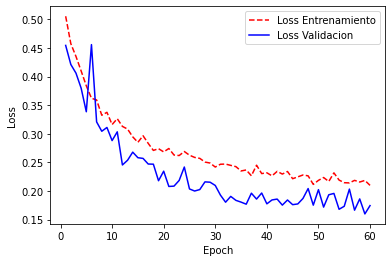

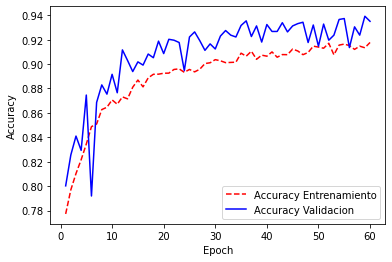

In [0]:
from keras.models import load_model

model = load_model("/content/gdrive/My Drive/Data/GenderDetectionReducido.hdf5")


## TEST
scores = model.evaluate(testdatagen.flow(x_test, y_test), verbose=11)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

import matplotlib.pyplot as plt

#NUMERO DE EPOCHS
num_epochs = range(1, len(history.history['loss']) + 1)

#GRAFICO DEL ENTRENAMIENTO
plt.plot(num_epochs, history.history['loss'], 'r--')
plt.plot(num_epochs, history.history['val_loss'], 'b-')
plt.legend(['Loss Entrenamiento', 'Loss Validacion'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

#GRAFICO DEL ENTRENAMIENTO ACCURACY
plt.plot(num_epochs, history.history['acc'], 'r--')
plt.plot(num_epochs, history.history['val_acc'], 'b-')
plt.legend(['Accuracy Entrenamiento', 'Accuracy Validacion'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()